In [1]:
import json

import csv
from typing import Dict, Optional, Set

def load_cluster_mapping(tsv_file: str) -> Dict[str, str]:
    protein_to_cluster = {}
    
    with open(tsv_file, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for line_num, row in enumerate(reader, 1):
            cluster_parent, protein_id = row
            protein_to_cluster[protein_id] = cluster_parent
    
    print(f"Total mappings loaded: {len(protein_to_cluster):,}")
    return protein_to_cluster

def extract_protein_ids(input_file):
    protein_ids = []
    ligand_ids = {}
    functional_annotations = {}
    prompts = {}
    
    with open(input_file, 'r') as f:
        for line_num, line in enumerate(f, 1):
            try:
                # Parse JSON from each line
                data = json.loads(line.strip())
                
                # Extract protein ID
                protein_id = data.get('uniprot_id')
                if protein_id:
                    protein_ids.append(protein_id)
                    
                    # Optional: print progress every 100k lines
                    if line_num % 1000000 == 0:
                        print(f"Processed {line_num:,} lines, found {len(protein_ids):,} protein IDs")
                
                ligand_id = data.get('input', {}).get('ligand_id')
                func_anno = data.get('input', {}).get('function_original')
                prompt = data.get('input', {}).get('function_full')

                if protein_id not in ligand_ids.keys():
                    ligand_ids[protein_id] = set()
                    ligand_ids[protein_id].add(ligand_id)
                else:
                    ligand_ids[protein_id].add(ligand_id)
                    
                if protein_id not in functional_annotations.keys():
                    functional_annotations[protein_id] = set()
                    functional_annotations[protein_id].add(func_anno)
                else:
                    functional_annotations[protein_id].add(func_anno)
                
                if protein_id not in prompts.keys():
                    prompts[protein_id] = set()
                    prompts[protein_id].add(prompt)
                else:
                    prompts[protein_id].add(prompt)
                
            except json.JSONDecodeError as e:
                print(f"Error parsing line {line_num}: {e}")
                continue
            except Exception as e:
                print(f"Unexpected error on line {line_num}: {e}")
                continue
    
    print(f"Total lines processed: {line_num:,}")
    print(f"Total protein IDs found: {len(protein_ids):,}")
    
    return protein_ids, ligand_ids, functional_annotations, prompts

In [2]:
dir = "/mnt/gemini/data/ramith/CMU-project/data/raw/data/output2/"
dir = "/mnt/gemini/data/ramith/CMU-project/data/splits_with_instruction/has_ligand/"

file = "train_dataset_tokenized.jsonl"
file = "val_dataset_tokenized.jsonl"
file = "valid.dataset_tokenized.jsonl"
file = "test.dataset_both_unseen_tokenized.jsonl"
# file = "combined_eval.jsonl"

In [3]:

protein_ids, ligand_ids_for_proteins, functional_annotations_for_proteins, prompts_for_proteins = extract_protein_ids(dir+file)

Total lines processed: 1,094
Total protein IDs found: 1,094


In [4]:
### count how many ligands for a protein at max
max_count = 0
for p_id, l_id in ligand_ids_for_proteins.items():
    max_count = max(max_count, len(l_id))
    
print("max ligands for a protein: ", max_count)

max ligands for a protein:  1


In [5]:
### count how many functional annotations for a protein at max
max_count = 0
for p_id, f_id in functional_annotations_for_proteins.items():
    max_count = max(max_count, len(f_id))
    
print("max annotations for a protein: ", max_count)

max annotations for a protein:  1


In [6]:
### count how many prompts for a protein at max
max_count = 0
for p_id, f_id in prompts_for_proteins.items():
    max_count = max(max_count, len(f_id))
    
print("max prompts for a protein: ", max_count)

max prompts for a protein:  1


In [7]:
len_protein_ids = len(protein_ids)
unique_protein_ids = len(set(protein_ids))

In [8]:
unique_protein_ids

1094

In [9]:
protein_ids[0]

'A0A830GVA3'

In [10]:
cluster_mapping_dir = "/mnt/gemini/data/ramith/CMU-project/data/raw/data/clusterRes_cluster.tsv"
cluster_mapping = load_cluster_mapping(cluster_mapping_dir)

Total mappings loaded: 7,718,246


In [11]:
uniprot_to_seq_file = "/mnt/gemini/data/ramith/CMU-project/data/raw/data/uniprot2seq.json"
# with open(uniprot_to_seq_file, 'r') as f:
#     sequence_mapping = json.load(f)

In [12]:
import ijson
def partial_load(json_path: str, needed_uniprot_ids: Set[str]) -> Dict[str, any]:
    result = {}
    try:
        with open(json_path, 'rb') as f:
            for key, value in ijson.kvitems(f, ''):
                if key in needed_uniprot_ids:
                    result[key] = value
    except FileNotFoundError:
        raise FileNotFoundError(f"JSON file not found: {json_path}")
    except Exception as e:  # Catch other potential parsing errors
        print(f"Error during partial loading of {json_path}: {e}")
    return result

In [13]:
uniprot2seq = partial_load(uniprot_to_seq_file, set(protein_ids))

In [14]:
protein_ids[0], uniprot2seq[protein_ids[0]]

('A0A830GVA3',
 'MTVTIVDHPLAQSILTMLRDRRTGQIEFRKGLVRLGRLMGYEVARSFPVSEVEVETPLGARARGVRLEVGDVVIIQILRAAMPMVEGLLKVFPMARMGVISARRREESHERGSMDFQIEMNYVRIPRIGRETTVMIVDPMLATGSTMLAAMRAIEERGEPGRMILINAIGTRQAVERVLAKKPVDIYLAAIDPEINEDGYIVPGLGDAGDRAYGEA')

In [15]:
cluster_mapping.get('A0A1C6H8Q5')

'A0A1C5N414'

In [16]:
## aggregate information of the clusters.

def add_to_cluster_info(protein_ids):
    cluster_info = {}
    
    for protein_id in protein_ids:
        cluster_id = cluster_mapping.get(protein_id)
        
        if cluster_id:
            # init a new cluster
            if cluster_id not in cluster_info:
                cluster_info[cluster_id] = {
                    'members': [],
                    'unique_members': [],
                    'lengths': [],
                    'unique_member_lengths': [],
                    'mean': 0,
                    'ligands': set(),
                    'ligand_count': 0,
                    'annotations': set(),
                    'ann_count': 0,
                    'prompts': set(),
                    'prompt_count' : 0,
                }

            # update info
            if(protein_id not in cluster_info[cluster_id]['unique_members']):
                cluster_info[cluster_id]['unique_members'].append(protein_id)
                cluster_info[cluster_id]['unique_member_lengths'].append(len(uniprot2seq[protein_id]))

            cluster_info[cluster_id]['members'].append(protein_id)

            cluster_info[cluster_id]['lengths'].append(len(uniprot2seq[protein_id]))
            
            ligands_for_protein =  ligand_ids_for_proteins.get(protein_id, [])
            f_ann_for_protein = functional_annotations_for_proteins.get(protein_id, [])
            prompts_for_protein = prompts_for_proteins.get(protein_id, [])
            
            for ligand_ in ligands_for_protein:
                cluster_info[cluster_id]['ligands'].add(ligand_)
            
            for annota in f_ann_for_protein:
                cluster_info[cluster_id]['annotations'].add(annota)
                
            for prompt in prompts_for_protein:
                cluster_info[cluster_id]['prompts'].add(prompt)
                
        else:
            print(f"Warning: Protein ID {protein_id} not found in cluster mapping.")
    
    for cluster_id, info in cluster_info.items():
        info['mean'] = sum(info['lengths']) / len(info['lengths'])
        info['min_length'] = min(info['lengths'])
        info['max_length'] = max(info['lengths'])
        info['std_dev'] = (sum((x - info['mean'])**2 for x in info['lengths']) / len(info['lengths']))**0.5
        info['ligand_count'] = len(info['ligands'])
        info['ann_count'] = len(info['annotations'])
        info['prompt_count'] = len(info['prompts'])
    
    print(f"Total clusters found: {len(cluster_info)}")
    return cluster_info

In [17]:
clusters = add_to_cluster_info(protein_ids)

Total clusters found: 5


In [18]:
clusters.keys()

dict_keys(['A0A2H1IVP2', 'A0A8C0YW85', 'A0A6L2LJY7', 'A0A9D9YZ36', 'W8TET3'])

In [19]:
for cluster_id, info in clusters.items():
    print(f"Cluster {cluster_id} has {len(info['members'])} proteins (u: {len(info['unique_members'])}) ; unique ligand associations: {info['ligands']}, mean length: {info['mean']:.2f}")

Cluster A0A2H1IVP2 has 664 proteins (u: 664) ; unique ligand associations: {'CHEBI_17568'}, mean length: 212.95
Cluster A0A8C0YW85 has 355 proteins (u: 355) ; unique ligand associations: {'CHEBI_61402'}, mean length: 207.66
Cluster A0A6L2LJY7 has 7 proteins (u: 7) ; unique ligand associations: {'CHEBI_61721'}, mean length: 299.00
Cluster A0A9D9YZ36 has 37 proteins (u: 37) ; unique ligand associations: {'CHEBI_57457'}, mean length: 452.46
Cluster W8TET3 has 31 proteins (u: 31) ; unique ligand associations: {'CHEBI_64716'}, mean length: 266.19


In [20]:
for cluster_id, info in clusters.items():
    lengths = info['lengths']
    min_len, max_len = info['min_length'], info['max_length']
    std_dev = info['std_dev']
    
    print(f"Cluster {cluster_id} has {len(info['members'])} proteins (u: {len(info['unique_members'])}); ligands: {info['ligands']} ### function text: {info['ann_count']} ### !!! # of prompts {info['prompt_count']} ### "
          f"mean: {info['mean']:.2f}, min: {min_len}, max: {max_len}, std: {std_dev:.2f}")

Cluster A0A2H1IVP2 has 664 proteins (u: 664); ligands: {'CHEBI_17568'} ### function text: 1 ### !!! # of prompts 10 ### mean: 212.95, min: 191, max: 425, std: 17.80
Cluster A0A8C0YW85 has 355 proteins (u: 355); ligands: {'CHEBI_61402'} ### function text: 2 ### !!! # of prompts 19 ### mean: 207.66, min: 150, max: 505, std: 38.72
Cluster A0A6L2LJY7 has 7 proteins (u: 7); ligands: {'CHEBI_61721'} ### function text: 1 ### !!! # of prompts 4 ### mean: 299.00, min: 116, max: 1250, std: 390.26
Cluster A0A9D9YZ36 has 37 proteins (u: 37); ligands: {'CHEBI_57457'} ### function text: 1 ### !!! # of prompts 10 ### mean: 452.46, min: 392, max: 553, std: 28.97
Cluster W8TET3 has 31 proteins (u: 31); ligands: {'CHEBI_64716'} ### function text: 1 ### !!! # of prompts 9 ### mean: 266.19, min: 241, max: 604, std: 63.62


In [21]:
clusters['A0A2H1IVP2']['ligands']

{'CHEBI_17568'}

In [22]:
import numpy as np

def farthest_first_subset(arr, arr_ids, m):
    """
    Return m maximally-spread elements from a 1-D numerical array.
    """
    assert len(arr) == len(arr_ids), "Array and IDs must have the same length"
    
    arr = np.asarray(arr)
    n = len(arr)
    if m >= n:
        print("Warning: m is greater than or equal to the number of elements in the array. Returning all elements.")
        return arr.tolist(), arr_ids

    # Using a mask to keep track of chosen points
    chosen_mask = np.zeros(n, dtype=bool)

    # 1. Start with an extreme element (here, the maximum)
    first_idx = np.argmax(arr)
    chosen_mask[first_idx] = True
    
    # This will hold the final chosen indices in order
    chosen_indices_in_order = [first_idx]

    # 2. Initialize distance to the nearest chosen element
    nearest_dist = np.abs(arr - arr[first_idx])

    # 3. Loop to select the remaining m-1 points
    for _ in range(1, m):
        # Before finding the next point ensure that all previously
        # chosen points have a distance of -1, so they can't be chosen again.
        nearest_dist[chosen_mask] = -1
        
        # Find the unchosen point whose nearest distance is largest (-1 never gets chosen)
        next_idx = np.argmax(nearest_dist)
        
        # Add the new point to our chosen set
        chosen_mask[next_idx] = True
        chosen_indices_in_order.append(next_idx)
        
        # Update the 'nearest' distances for all points
        nearest_dist = np.minimum(nearest_dist, np.abs(arr - arr[next_idx]))

    # 4. Collect results based on the final list of chosen indices
    chosen_vals = arr[chosen_indices_in_order].tolist()
    chosen_ids = [arr_ids[i] for i in chosen_indices_in_order]
    
    return chosen_vals, chosen_ids

In [23]:
lengths = [10, 20, 80, 90, 100, 200, 210, 220, 500] 
p_ids   = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']
m = 4 # We want to select the 4 largest proteins

print(f"Original lengths: {lengths}\n")

selected_lengths, selected_ids = farthest_first_subset(lengths, p_ids, m)

print(f"--- Selected the m={m} largest elements ---")
# Sorting the results here just for a clean display
print(f"Selected lengths: {selected_lengths}")
print(f"Corresponding protein IDs: {selected_ids}")


Original lengths: [10, 20, 80, 90, 100, 200, 210, 220, 500]

--- Selected the m=4 largest elements ---
Selected lengths: [500, 10, 220, 100]
Corresponding protein IDs: ['p9', 'p1', 'p8', 'p5']


In [24]:
# clusters.keys()

In [25]:
# ligand_ids_for_proteins['A0A830GVA3']

In [26]:
# proteins_in_this_cluster = clusters['A0A2H1IVP2']['unique_members']
# ligands_in_this_cluster = clusters['A0A2H1IVP2']['ligands']

In [27]:
# ligands_in_this_cluster


In [28]:
# len(proteins_in_this_cluster)

In [29]:
def downsample_cluster(cluster_, m, skew_ = 0.0, cluster_sampling_quota = None):
    to_downsample = {}
    
    easy_to_downsample = []

    for cluster_name in cluster_.keys():
        #print("working on cluster: ", cluster_name)
        to_downsample[cluster_name] = {}
        
        ligands_in_this_cluster = clusters[cluster_name]['ligands']
        unique_proteins_in_this_cluster = clusters[cluster_name]['unique_members']
        # unique_lengths_in_this_cluster = clusters[cluster_name]['unique_member_lengths']
        
        
        if(cluster_sampling_quota != None):
            proteins_to_select_per_ligand = cluster_sampling_quota[cluster_name] // len(ligands_in_this_cluster)
        else:
            proteins_to_select_per_ligand = m // len(ligands_in_this_cluster)
        
        #print(" proteins to select per ligand: ", proteins_to_select_per_ligand)
        for ligand_ in ligands_in_this_cluster:
            #print("     working on ligand: ", ligand_)
                        
            unique_proteins_for_this_ligand = [protein_ for protein_ in unique_proteins_in_this_cluster if ligand_ in ligand_ids_for_proteins[protein_]]
            unique_protein_lengths_for_this_ligand = [len(uniprot2seq[protein_]) for protein_ in unique_proteins_for_this_ligand]
            
            assert len(unique_proteins_for_this_ligand) == len(set(unique_proteins_for_this_ligand))
            
            #print("passing these two arrays to farthest_first_subset: ", unique_protein_lengths_for_this_ligand, unique_proteins_for_this_ligand)
            #most_diverse_lengths, protein_ids_with_most_diverse_length = select_largest_m(unique_protein_lengths_for_this_ligand, unique_proteins_for_this_ligand, proteins_to_select_per_ligand)
            most_diverse_lengths, protein_ids_with_most_diverse_length = farthest_first_subset(unique_protein_lengths_for_this_ligand, unique_proteins_for_this_ligand, proteins_to_select_per_ligand)
            
            assert len(protein_ids_with_most_diverse_length) == len(set(protein_ids_with_most_diverse_length))
            
            #print("got these most diverse lengths: ", most_diverse_lengths)
            to_downsample[cluster_name][ligand_] = (protein_ids_with_most_diverse_length, most_diverse_lengths)

            for protein_ in protein_ids_with_most_diverse_length:
                easy_to_downsample.append((protein_, ligand_))

    return to_downsample, easy_to_downsample

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_length_distributions_with_original(downsampled_data: dict, original_data: dict, text=""):
    """
    Plots the downsampled distribution overlaid on the original distribution
    for each cluster and for the overall total.

    Args:
        downsampled_data: A dictionary from your downsampling function.
                          Structure: {cluster_id: {ligand_id: (protein_ids, lengths)}}
        original_data: The full cluster dictionary before downsampling.
                       Structure from add_to_cluster_info: {cluster_id: {'lengths': [...]}}
        text: An optional title for the plot.
    """
    # Use the keys from the downsampled data to determine which clusters to plot
    cluster_ids = list(downsampled_data.keys())
    num_clusters = len(cluster_ids)

    if num_clusters == 0:
        print("The downsampled data dictionary is empty. Nothing to plot.")
        return

    # --- Determine the grid size for the subplots ---
    num_plots = num_clusters + 1
    ncols = math.ceil(math.sqrt(num_plots))
    nrows = math.ceil(num_plots / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
    axes = axes.flatten()

    # --- Master lists for the "Overall" plot ---
    total_downsampled_lengths = []
    total_original_lengths = []

    # --- Plot the distribution for each individual cluster ---
    for i, cluster_id in enumerate(cluster_ids):
        ax = axes[i]

        # 1. Plot the ORIGINAL distribution in the background
        original_cluster_lengths = original_data.get(cluster_id, {}).get('lengths', [])
        total_original_lengths.extend(original_cluster_lengths)
        
        if original_cluster_lengths:
            ax.hist(original_cluster_lengths, bins=50, color='lightgray', 
                    label=f"Original (n={len(original_cluster_lengths)})", zorder=1)

        # 2. Plot the DOWNSAMPLED distribution in the foreground
        downsampled_cluster_lengths = []
        for ligand_id, (protein_ids, lengths) in downsampled_data.get(cluster_id, {}).items():
            downsampled_cluster_lengths.extend(lengths)
        total_downsampled_lengths.extend(downsampled_cluster_lengths)

        if downsampled_cluster_lengths:
            ax.hist(downsampled_cluster_lengths, bins=50, color='skyblue', edgecolor='black',
                    label=f"Downsampled (n={len(downsampled_cluster_lengths)})", zorder=2)
        
        # 3. Add labels, title, and legend
        ax.set_title(f"Cluster: {cluster_id}", fontsize=12)
        ax.set_xlabel("Protein Length")
        ax.set_ylabel("Frequency")
        ax.grid(axis='y', alpha=0.75)
        ax.legend()

    # --- Plot the total distribution in the next available subplot ---
    ax_total = axes[num_clusters]
    if total_original_lengths:
        ax_total.hist(total_original_lengths, bins=50, color='lightgray',
                      label=f"Original (n={len(total_original_lengths)})", zorder=1)
    if total_downsampled_lengths:
        ax_total.hist(total_downsampled_lengths, bins=50, color='salmon', edgecolor='black',
                      label=f"Downsampled (n={len(total_downsampled_lengths)})", zorder=2)
    
    ax_total.set_title(f"Overall Distribution", fontsize=12, weight='bold')
    ax_total.set_xlabel("Protein Length")
    ax_total.set_ylabel("Frequency")
    ax_total.grid(axis='y', alpha=0.75)
    ax_total.legend()

    # --- Clean up any remaining empty subplots ---
    for i in range(num_plots, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout(pad=3.0)
    plt.suptitle(f"Protein Length Distributions: Downsampled vs. Original ({text})", fontsize=16, y=1.02)
    plt.show()

def plot_length_distributions(downsampled_data: dict, text=""):
    """
    Plots the protein length distribution for each cluster and one overall
    distribution for all clusters combined.

    Args:
        downsampled_data: A dictionary with the structure:
                          {cluster_id: {ligand_id: (protein_ids, lengths)}}
    """
    cluster_ids = list(downsampled_data.keys())
    num_clusters = len(cluster_ids)

    if num_clusters == 0:
        print("The data dictionary is empty. Nothing to plot.")
        return

    # --- Determine the grid size for the subplots ---
    # We now need space for each cluster PLUS one for the total distribution.
    num_plots = num_clusters + 1
    ncols = math.ceil(math.sqrt(num_plots))
    nrows = math.ceil(num_plots / ncols)

    # --- Create the figure and subplots ---
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    # Flatten the axes array to make it easy to iterate over
    axes = axes.flatten()

    # --- Collect all lengths into a single list for the total plot ---
    total_lengths = []

    # --- Plot the distribution for each individual cluster ---
    for i, cluster_id in enumerate(cluster_ids):
        ax = axes[i]
        
        # Collect all lengths from all ligands within this cluster
        cluster_lengths = []
        for ligand_id, (protein_ids, lengths) in downsampled_data[cluster_id].items():
            cluster_lengths.extend(lengths)
        
        # Add these lengths to our master list for the final plot
        total_lengths.extend(cluster_lengths)

        if not cluster_lengths:
            ax.set_title(f"Cluster: {cluster_id}\n(No data to plot)")
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Create a histogram for the current cluster's lengths
        ax.hist(cluster_lengths, bins=50, color='skyblue', edgecolor='black')
        
        # Add labels and title for clarity
        ax.set_title(f"Cluster: {cluster_id}\n(n={len(cluster_lengths)})", fontsize=12)
        ax.set_xlabel("Protein Length")
        ax.set_ylabel("Frequency")
        ax.grid(axis='y', alpha=0.75)

    # --- Plot the total distribution in the next available subplot ---
    if total_lengths:
        ax_total = axes[num_clusters] # Use the subplot right after the last cluster
        ax_total.hist(total_lengths, bins=50, color='salmon', edgecolor='black')
        ax_total.set_title(f"Overall Distribution\n(n={len(total_lengths)})", fontsize=12, weight='bold')
        ax_total.set_xlabel("Protein Length")
        ax_total.set_ylabel("Frequency")
        ax_total.grid(axis='y', alpha=0.75)


    # --- Clean up any remaining empty subplots ---
    for i in range(num_plots, len(axes)):
        axes[i].set_visible(False)

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout(pad=3.0)
    plt.suptitle(f"Protein Length Distributions of Downsampled Clusters ({text})", fontsize=16, y=1.02)
    plt.show()



dict_keys(['A0A2H1IVP2', 'A0A8C0YW85', 'A0A6L2LJY7', 'A0A9D9YZ36', 'W8TET3'])
127


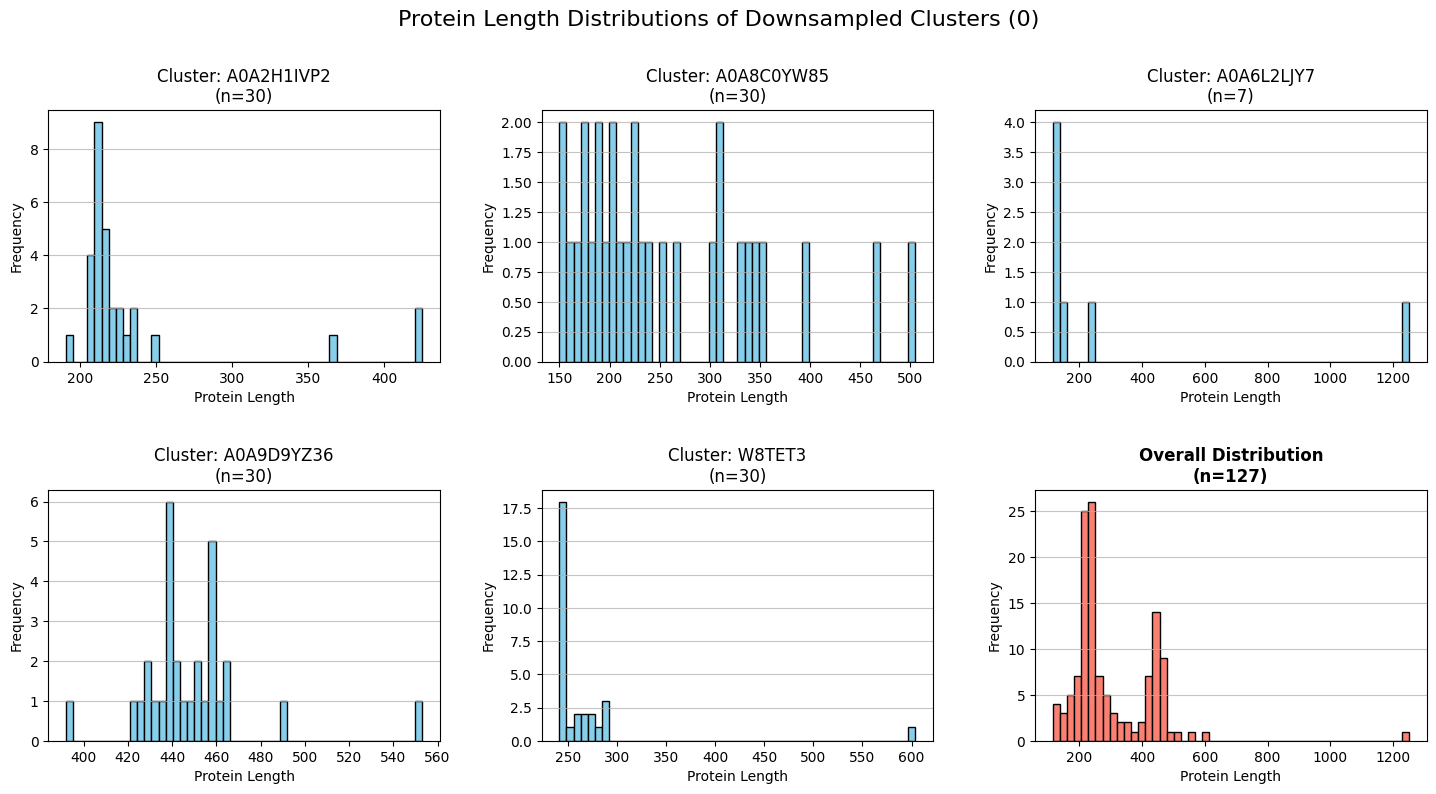

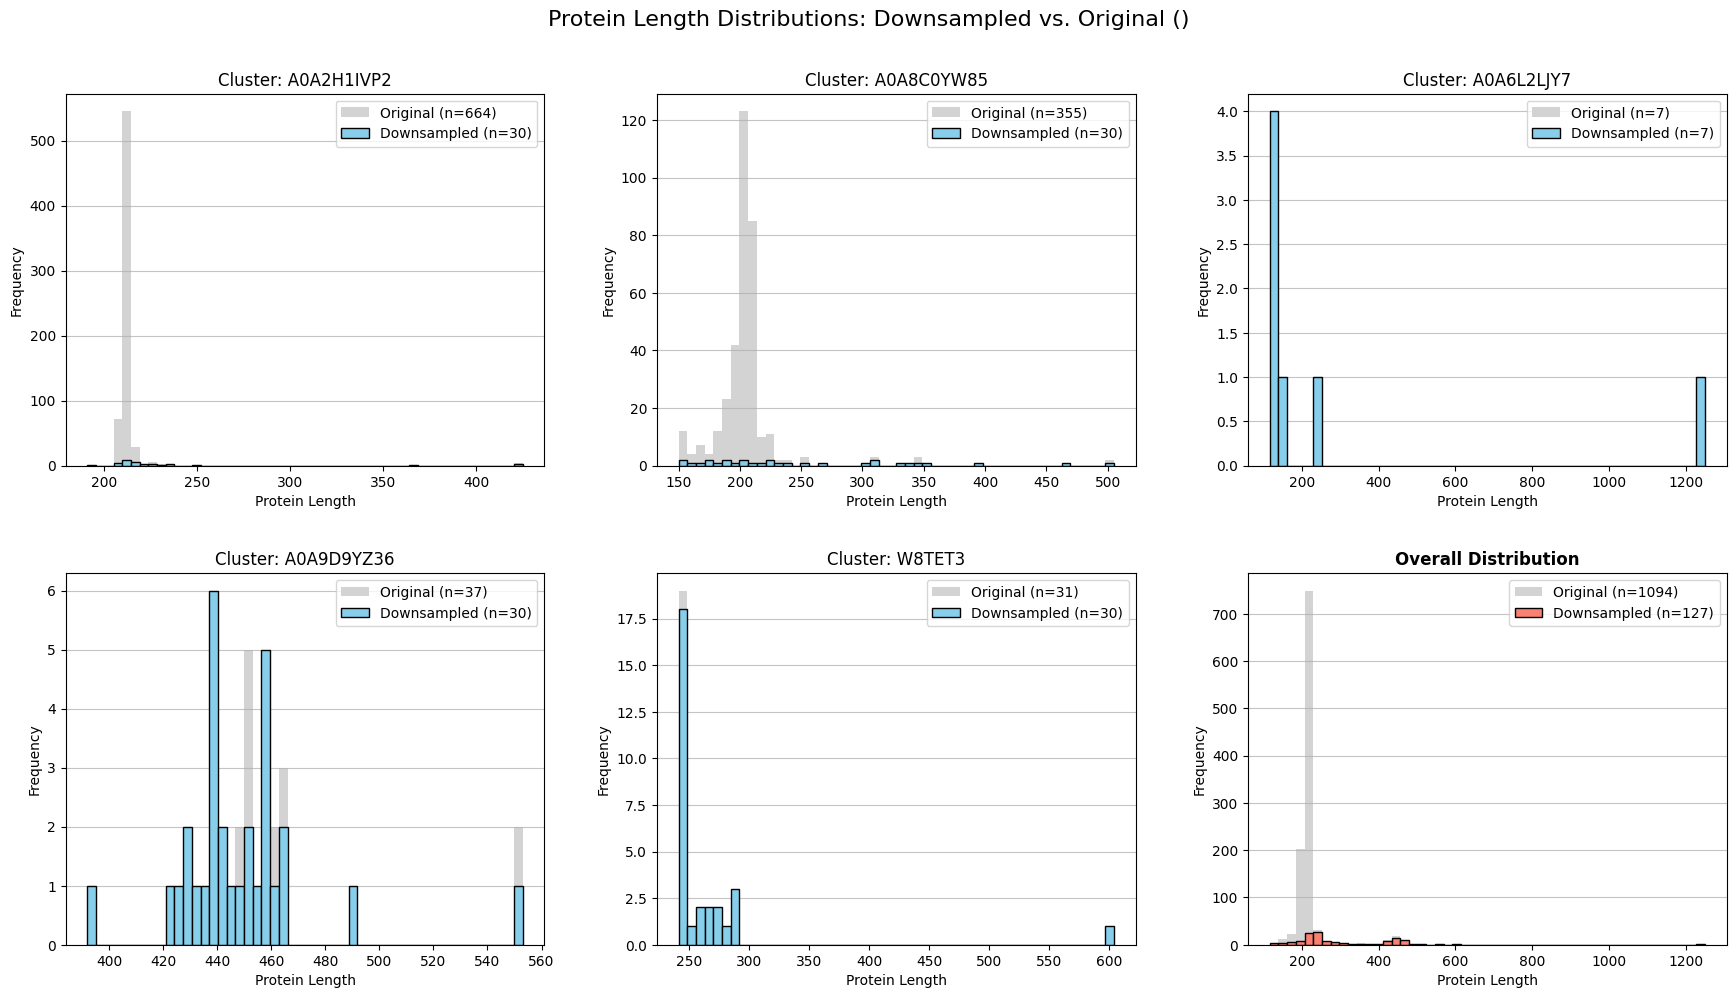

In [31]:
skew_ = 0
count = 30

sampling_quota = {}

# ## add the keys with defualt values
# for cluster_id in clusters.keys():
#     sampling_quota[cluster_id] = count # default value, can be changed later

# # sampling_quota['A0A2H1IVP2'] = 5

to_downsample, easy_to_downsample = downsample_cluster(clusters, count, skew_)
print(to_downsample.keys())
print(len(easy_to_downsample))
plot_length_distributions(to_downsample, skew_)
plot_length_distributions_with_original(to_downsample, clusters, "")

In [32]:
type(easy_to_downsample)

list

In [33]:

# from helpers2 import plot_length_distributions_with_original2, plot_length_distributions_with_original_
# plot_length_distributions_with_original_(to_downsample, original, "")

In [34]:
filepath = 'allow_list.tsv'
allow_list = easy_to_downsample

with open(filepath, 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    # Write a header for clarity
    writer.writerow(['protein_id', 'ligand_id'])
    # Write all the data rows
    writer.writerows(allow_list)
print("Save complete.")

Save complete.


In [35]:
easy_to_downsample[:-10]

[('A0A2H1IVP2', 'CHEBI_17568'),
 ('A0A0R2KHZ0', 'CHEBI_17568'),
 ('R7Y2F7', 'CHEBI_17568'),
 ('A0A653S8X9', 'CHEBI_17568'),
 ('A0A916T420', 'CHEBI_17568'),
 ('A0A0S8KS33', 'CHEBI_17568'),
 ('A0A1D7W0N7', 'CHEBI_17568'),
 ('A0A6J4M004', 'CHEBI_17568'),
 ('A0A2H1IKV4', 'CHEBI_17568'),
 ('A0A543BCR3', 'CHEBI_17568'),
 ('A0A830GVA3', 'CHEBI_17568'),
 ('A0A0F0KK16', 'CHEBI_17568'),
 ('A0A7X7RU45', 'CHEBI_17568'),
 ('A0A946RIN7', 'CHEBI_17568'),
 ('A0A031I5R7', 'CHEBI_17568'),
 ('A0A2H1IFU2', 'CHEBI_17568'),
 ('A0A2H1L2R1', 'CHEBI_17568'),
 ('A0A117SW07', 'CHEBI_17568'),
 ('I7IY78', 'CHEBI_17568'),
 ('A0A1C6D3C9', 'CHEBI_17568'),
 ('F3BGA3', 'CHEBI_17568'),
 ('A0A2W6DL54', 'CHEBI_17568'),
 ('A0A938FEL4', 'CHEBI_17568'),
 ('D0WGA9', 'CHEBI_17568'),
 ('A0A3D5Q5J1', 'CHEBI_17568'),
 ('A0A7W5XPI9', 'CHEBI_17568'),
 ('A0A6N2S4G3', 'CHEBI_17568'),
 ('A0A6J4KIA7', 'CHEBI_17568'),
 ('A0A8F2JAN2', 'CHEBI_17568'),
 ('I7JRV1', 'CHEBI_17568'),
 ('A0A8C0PEU2', 'CHEBI_61402'),
 ('A0A5F4WMD1', 'CHEBI_61402